## Deep Learning Spring 24 - Mini Project
Image classification on CIFAR-10 dataset with ResNet (parameters<5 million)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-test-competition/cifar_test_nolabels.pkl

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_1

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_2

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/batches.meta

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_3

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_5

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_4

/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/readme.html


## Environment Prep
Load required libraries, check for GPU

In [ ]:
import torch
import numpy as np
!pip install torchinfo

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


## Data Management
Load kaggle datasets into torch Dataset objects.<br>
Combine all 5 batches into one for training<br>
Load CIFAR-10 test dataset<br>
Load test dataset (test_no_labels.pkl)<br>
Transform training dataset with horizontal flip, random crop and normalization<br>
Transform test dataset with normalization<br>
Split training set into train and validation sets<br>



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchinfo import summary

d1=[]
l1=[]
d2=[]
l2=[]
id2=[]
d3 = []
l3 = []
cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
with open(os.path.join(cifar10_dir,'data_batch_1'),'rb') as f:
    entry=pickle.load(f, encoding="latin1")
    d1.append(entry["data"])
    if "labels" in entry:
        l1.extend(entry["labels"])
with open(os.path.join(cifar10_dir,'data_batch_2'),'rb') as f:
    entry=pickle.load(f, encoding="latin1")
    d1.append(entry["data"])
    if "labels" in entry:
        l1.extend(entry["labels"])

with open(os.path.join(cifar10_dir,'data_batch_3'),'rb') as f:
    entry=pickle.load(f, encoding="latin1")
    d1.append(entry["data"])
    if "labels" in entry:
        l1.extend(entry["labels"])

with open(os.path.join(cifar10_dir,'data_batch_4'),'rb') as f:
    entry=pickle.load(f, encoding="latin1")
    d1.append(entry["data"])
    if "labels" in entry:
        l1.extend(entry["labels"])
with open(os.path.join(cifar10_dir,'data_batch_5'),'rb') as f:
    entry=pickle.load(f, encoding="latin1")
    d1.append(entry["data"])
    if "labels" in entry:
        l1.extend(entry["labels"])
d1=np.vstack(d1).reshape(-1,3,32,32)
d1=d1.transpose((0,2,3,1))

with open(os.path.join(cifar10_dir,'test_batch'),'rb') as f:
    entry=pickle.load(f, encoding="latin1")
    d3.append(entry["data"])
    if "labels" in entry:
        l3.extend(entry["labels"])
d3=np.vstack(d3).reshape(-1,3,32,32)
d3=d3.transpose((0,2,3,1))

with open('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl','rb') as f:
    entry=pickle.load(f, encoding="latin1")
    print(entry)
    d2.extend(entry[b'data'])
    id2.extend(entry[b'ids'])
    if "labels" in entry:
        l2.extend(entry["labels"])
l2.extend(id2)
d2=np.vstack(d2).reshape(-1,3,32,32)
d2=d2.transpose((0,2,3,1))


class CIFARDataset(Dataset):

    def __init__(self, X_Train, Y_Train, transform=None):
        self.data = X_Train
        self.targets = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

#Only the data is normalaized, we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = CIFARDataset(d1,l1,transform_train)
test_data = CIFARDataset(d3, l3, transform_test)
actual_test_data = CIFARDataset(d2,l2,transform_test)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)
actual_test_loader = torch.utils.data.DataLoader(actual_test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']



{b'data': array([[133, 136, 136, ..., 226, 225, 224],

       [160, 177, 176, ...,  89,  89,  88],

       [255, 255, 255, ..., 211, 213, 215],

       ...,

       [ 29,  29,  45, ..., 156, 155, 154],

       [124, 123, 126, ...,  49,  49,  51],

       [255, 255, 255, ..., 250, 251, 255]], dtype=uint8), b'ids': array([   0,    1,    2, ..., 9997, 9998, 9999])}

==> Preparing data..



50000    10000


## Visualize a few images

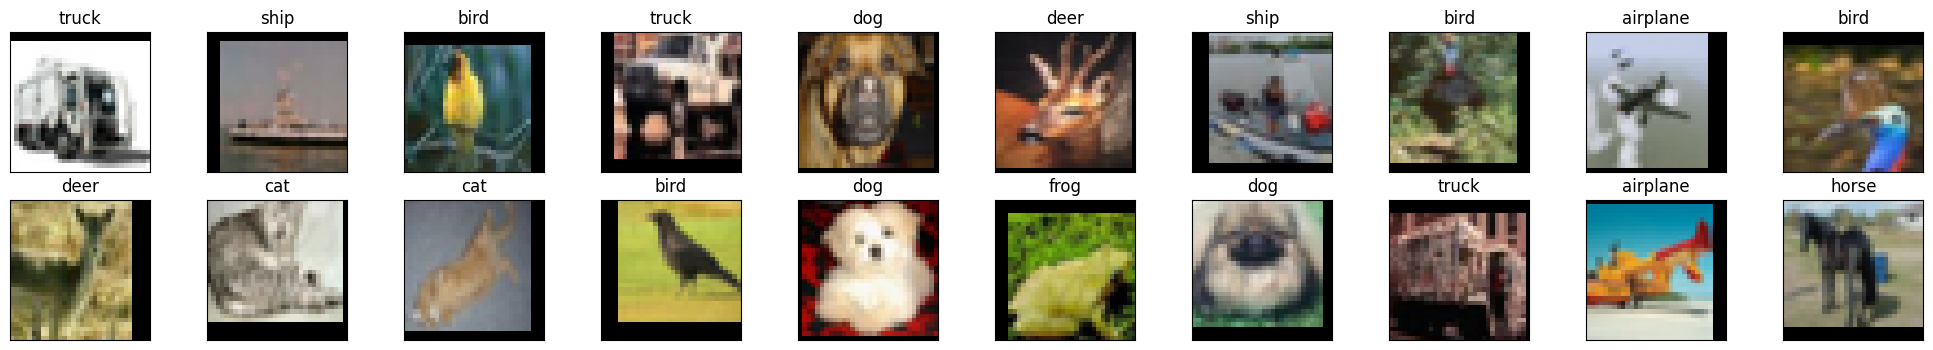

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

## ResNet Definition
Define a resnet block as two convolution layers with batch normalization and ReLu activation. Add a skip connection to each block. <br>
Define the ResNet as 3 layers of blocks with 64,128 and 256 slices.<br>
Last layer of ResNet - Pooling and Dense layer

In [ ]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

#Residual block definition
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    #Skip connection definition
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out



class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    # 3 layers of residual blocks
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.linear = nn.Linear(1024*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    # Average Pooling
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    # Dense Layer
    out = self.linear(out)
    return out

#Two layers each of resnet blocks
ResNet18 = ResNet(BasicBlock, [2,2,2])


print(ResNet18)

if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

ResNet(

  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (layer1): Sequential(

    (0): BasicBlock(

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (shortcut): Sequential()

    )

    (1): BasicBlock(

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn2): BatchNorm2d(64, eps=1e-05, moment

## Resnet parameters and structure

In [ ]:
summary(ResNet18)

Layer (type:depth-idx)                        Param #
DataParallel                                  --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            1,728
│    └─BatchNorm2d: 2-2                       128
│    └─Sequential: 2-3                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-4                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Linear: 2-6                            10,250
Total params: 2,785,354
Trainable params: 2,785,354
Non-trainable params: 0

## Loss and Optimizer
Cross entropy loss chosen. SGD for optimizer with learning rate 0.01.

In [ ]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

## Training and validation
Perform 100 epochs of training, each with mini batches of 20 samples. Validate on the validation set to obtain model with least loss. Store the best model.

In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

loss_history_ep = []
loss_history_tr = []
loss_history_va = []

for epoch in range(1, n_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  ###################
  # train the model #
  ###################
  ResNet18.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)

  ######################
  # validate the model #
  ######################
  ResNet18.eval()
  for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss
    valid_loss += loss.item()*data.size(0)

  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  loss_history_e.append(epoch)
  loss_history_tr.append(train_loss)
  loss_history_va.append(valid_loss)
  # print training/validation statistics
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))

  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(ResNet18.state_dict(), '/kaggle/working/ResNet18.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.601887 	Validation Loss: 1.205334

Validation loss decreased (inf --> 1.205334).  Saving model ...

Epoch: 2 	Training Loss: 1.089670 	Validation Loss: 0.876252

Validation loss decreased (1.205334 --> 0.876252).  Saving model ...

Epoch: 3 	Training Loss: 0.859796 	Validation Loss: 0.776128

Validation loss decreased (0.876252 --> 0.776128).  Saving model ...

Epoch: 4 	Training Loss: 0.725854 	Validation Loss: 0.702403

Validation loss decreased (0.776128 --> 0.702403).  Saving model ...

Epoch: 5 	Training Loss: 0.629042 	Validation Loss: 0.591279

Validation loss decreased (0.702403 --> 0.591279).  Saving model ...

Epoch: 6 	Training Loss: 0.558566 	Validation Loss: 0.548565

Validation loss decreased (0.591279 --> 0.548565).  Saving model ...

Epoch: 7 	Training Loss: 0.503817 	Validation Loss: 0.524748

Validation loss decreased (0.548565 --> 0.524748).  Saving model ...

Epoch: 8 	Training Loss: 0.458573 	Validation Loss: 0.487759

Validation loss dec

Load the best model for testing

In [ ]:
#Plot loss over epochs
plt.figure()
plt.plot(loss_history_e, loss_history_tr, label="Training Loss")
plt.plot(loss_history_e, loss_history_va, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
ResNet18.load_state_dict(torch.load('/kaggle/working/ResNet18.pt'))

<All keys matched successfully>

## Testing
Use the test dataset to determine accuracy and test loss.<br>
Determine test accuracy for each class

In [ ]:
# track classwise test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

ResNet18.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = ResNet18(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Results saved


## Evaluation/Inference
Use the actual competition test dataset to perform inference for the CSV file

In [ ]:
#Track Image Id and prediction
test_ids=[]
test_labels=[]
tst_lbl=[]
ctr=0

ResNet18.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(actual_test_loader):
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = ResNet18(data)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  test_labels.append(pred)

#Reformat predictions to generate CSV output
for i in test_labels:
    test_ids.extend(list(range(ctr,ctr+20)))
    ctr+=20
    tst_lbl.extend(i.tolist())

#CSV output
df_data = []
for i in test_ids:
    df_data.append([i,tst_lbl[i]])
df=pd.DataFrame(df_data,columns=["ID","Labels"])
df.to_csv('/kaggle/working/result.csv',index=False)
print('Results saved')